In [384]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [385]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [386]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [387]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [388]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)


In [389]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [390]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [391]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [392]:
# Find the most recent date in the data set.
from sqlalchemy import desc
most_recent_entry = session.query(Measurement).order_by(desc(Measurement.date)).first()

if most_recent_entry:
    print(f"Most recent entry: Date={most_recent_entry.date}")
else:
    print("No entries found.")

Most recent entry: Date=2017-08-23


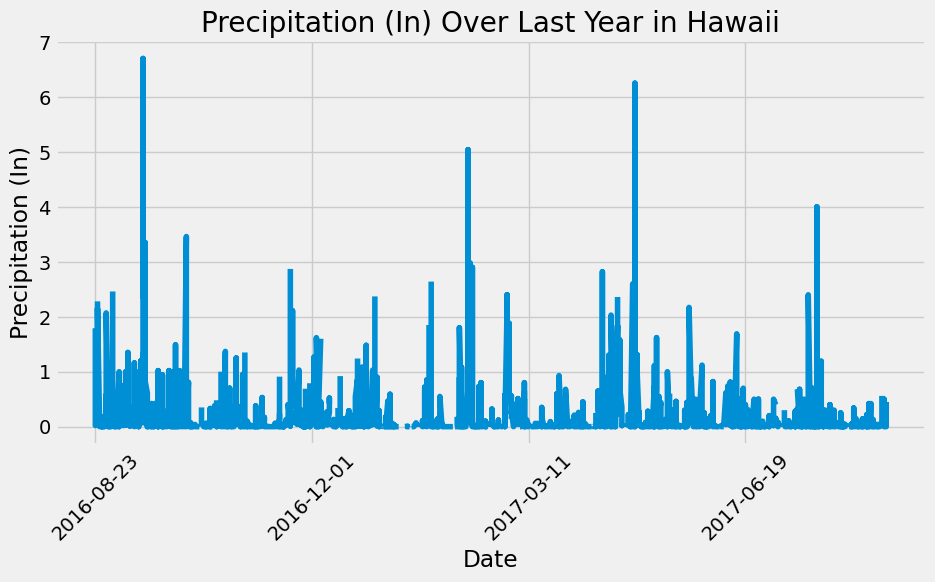

In [393]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime
from dateutil.relativedelta import relativedelta

if most_recent_entry:
    most_recent_date = most_recent_entry.date

    # Convert 'datestring' to date
    if isinstance(most_recent_date, str):
        most_recent_date = datetime.strptime(most_recent_date, "%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.
    one_year_ago = most_recent_date - relativedelta(months = 12)

# Perform a query to retrieve the data and precipitation scores
    measurements_last_12m = session.query(Measurement).filter(
        Measurement.date.between(one_year_ago, most_recent_date)
    ).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

last_year_data = [
    {'Date': measurement.date, 'Precipitation (Inches)': measurement.prcp}
    for measurement in measurements_last_12m
]

last_yr_dataframe = pd.DataFrame(last_year_data)

last_yr_dataframe

# Sort the dataframe by date
last_yr_dataframe = last_yr_dataframe.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,5))
plt.plot(last_yr_dataframe['Date'], last_yr_dataframe['Precipitation (Inches)'])
plt.title('Precipitation (In) Over Last Year in Hawaii')
plt.xlabel('Date')
plt.ylabel('Precipitation (In)')
plt.grid(True)
plt.xticks(rotation=45)

# Reduce the number of x ticks (Thanks ChatGPT)
from matplotlib.ticker import MaxNLocator
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout
plt.show()

In [394]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(last_yr_dataframe.describe())

       Precipitation (Inches)
count             2021.000000
mean                 0.177279
std                  0.461190
min                  0.000000
25%                  0.000000
50%                  0.020000
75%                  0.130000
max                  6.700000


# Exploratory Station Analysis

In [395]:
# Design a query to calculate the total number of stations in the dataset

unique_station_count = session.query(func.count(func.distinct(Measurement.station))).scalar()
print("Number of stations:", unique_station_count)


Number of stations: 9


In [396]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count')) \
                              .group_by(Measurement.station) \
                              .order_by(func.count(Measurement.station).desc()) \
                              .all()

# List the stations and their counts in descending order.
most_active_list = [(station, count) for station, count in most_active_stations]

print("Most active stations, in descending order:")
for station, count in most_active_list:
    print(f"Station: {station}, Count: {count}")

Most active stations, in descending order:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [397]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'

most_active_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                        .filter(Measurement.station == most_active_station) \
                        .first()

if most_active_query:
    lowest_temperature = most_active_query[0]
    highest_temperature = most_active_query[1]
    average_temperature = most_active_query[2]

    print(f"Lowest temperature: {lowest_temperature}")
    print(f"Highest temperature: {highest_temperature}")
    print(f"Average temparature: {average_temperature}")
else:
    print("Error: No temperature data for given station")

Lowest temperature: 54.0
Highest temperature: 85.0
Average temparature: 71.66378066378067


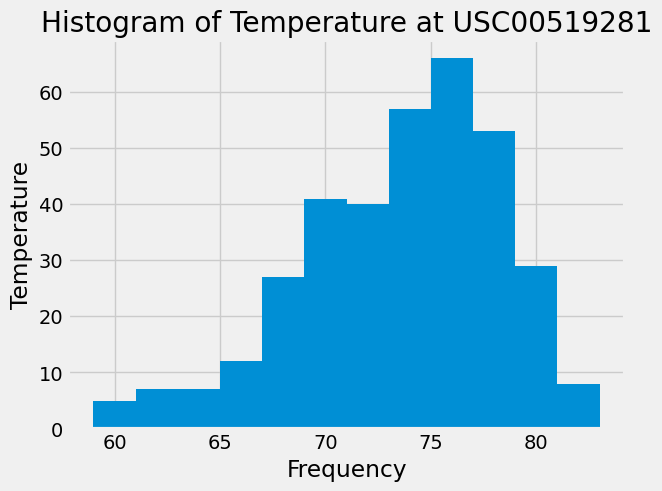

In [398]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

oneyear_most_active_query = session.query(Measurement) \
                         .filter(Measurement.station == most_active_station) \
                         .filter(Measurement.date.between(one_year_ago, most_recent_date)) \
                         .all()

oneyear_most_active_data = [
    {'Date': measurement.date, 'Temperature': measurement.tobs}
    for measurement in oneyear_most_active_query]

oneyear_most_active_df = pd.DataFrame(oneyear_most_active_data)

oneyear_most_active_df.hist(bins= 12)
plt.xlabel('Frequency')
plt.ylabel('Temperature')
plt.title(f'Histogram of Temperature at {most_active_station}')
plt.show()



# Close Session

In [399]:
# Close Session
session.close()